In [1]:
from Tools.tools_init_ import *
from Libs.libs import *

from Libs.libs import llm
from Libs.libs import llm


import functools
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict
from Redis.utilis import RedisSaver
from Agent.supervisor_agent import agent_node, supervisor_agent_make

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from Libs.libs import *
from Tools.tools_init_ import GetCustomTools
from Tools.availability_by_doctor import check_availability_by_doctor
from Tools.availability_by_specialization import check_availability_by_specialization
from Tools.booking import book_appointment
from Tools.reschedule import reschedule
from Tools.ragAgent import rag_tool


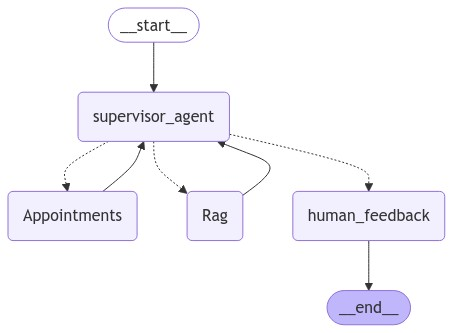

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': [HumanMessage(content='book an appointment with doctor kevin anderson for october 3 2024 16:00?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='book an appointment with doctor kevin anderson for october 3 2024 16:00?', additional_kwargs={}, response_metadata={})]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='book an appointment with doctor kevin anderson for october 3 2024 16:00?', additional_kwargs={}, response_metadata={})]}
[1:tasks] Starting step 1 with 1 task:
- supervisor_agent -> {'messages': [HumanMessage(content='book an appointment with doctor kevin anderson for october 3 2024 16:00?', additional_kwargs={}, response_metadata={})]}
Inside should continue Appointments
[1:writes] Finished step 1 with writes to 1 channel:
- next -> 

In [5]:
from Tools.tools_init_ import *
from Libs.libs import *

from Libs.libs import llm
from Libs.libs import llm


import functools
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict
from Redis.utilis import RedisSaver
from Agent.supervisor_agent import agent_node, supervisor_agent_make

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from Libs.libs import *
from Tools.tools_init_ import GetCustomTools
from Tools.availability_by_doctor import check_availability_by_doctor
from Tools.availability_by_specialization import check_availability_by_specialization
from Tools.booking import book_appointment
from Tools.reschedule import reschedule
from Tools.ragAgent import rag_tool, create_custom_agent

query = "book an appointment with doctor kevin anderson for october 3 2024 16:00?"



def read_human_feedback(state):
    return state

class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

        
def should_continue(state: MessagesState) -> Literal["Rag","Appointments"]:
    print("Inside should continue", state['next'])
    if state['next'] == "FINISH":
        return "human_feedback"
    return state['next']
    # messages = state['messages']
    # print("message",messages)
    # last_message = messages[-1]
    # print("from should continue",last_message)
    # if isinstance(last_message,routeResponse):
    #     return f"{last_message.next}"
    # return last_message

       
        
toolsInstance = GetCustomTools()
tools_available = toolsInstance.get_tools()

class routeResponse(BaseModel):
    next: Literal["Appointments", "Rag", "FINISH"]

from Tools.ragAgent import create_custom_agent
Appointments_agnet = create_custom_agent(prompt="""You are an intelligent agent that answers queries related to the appointment with doctor based on doctor name, specialization, schedule appointment and reschedule appoinments.""", tools=tools_available, )
Appointments_node = functools.partial(agent_node, agent=Appointments_agnet, name="Appointments")

Rag_agent = create_custom_agent(prompt="""You are an intelligent agent that answers queries related to TATA Punch EV vehicles and its variants.""", tools=[rag_tool] )

Rag_node = functools.partial(agent_node, agent=Rag_agent, name="Rag")
workflow = StateGraph(AgentState)
workflow.add_node("Appointments", Appointments_node)
workflow.add_node("Rag", Rag_node)
workflow.add_node("supervisor_agent", supervisor_agent_make)
workflow.add_node("human_feedback", read_human_feedback)

# workflow.add_edge("Appointments", "supervisor_agent")
conditional_map = {'Appointments': 'Appointments', 'Rag': 'Rag', 'FINISH': '__end__'}
# workflow.add_conditional_edges("supervisor_agent", lambda x: x["next"], conditional_map)

workflow.add_conditional_edges(
"supervisor_agent",
should_continue,
        {
            "Rag":"Rag",
            "Appointments":"Appointments",
            "human_feedback":"human_feedback"
            }
    )
workflow.add_edge(
    "human_feedback",END
)

workflow.add_edge(
    "Appointments","supervisor_agent",
)



workflow.add_edge(
    "Rag","supervisor_agent",)
        
        
        
workflow.add_edge(START, "supervisor_agent")
graph = workflow.compile(debug=True)



        # from Agent.agent_take2 import *
from Libs.libs import *
# from graph import  graph
from IPython.display import Image, display



display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

for s in graph.stream({"messages": [HumanMessage(content=query)]},{"recursion_limit": 100}):
    if "__end__" not in s:
        if 'human_feedback' in s:
            mdprint(s['human_feedback']['messages'][-1].content)
            print()
            print()
            break
        print(s)
        print()
        print()
        print()
        print("This is s.,.,.,.",s)
        print("----")
    else:
        print(s)
